<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>



## Purpose
This projects is partly to portray my skills to extract and analyze data.

In this project I set out analyse Bouroughs(Big Neighbourhoods) and segment and cluster them based on the types of venues or attractions that surround that respective Borough.

This Project is divided into four parts:
1. Scraping the data off the internet and create a dataframe.
2. Get the location of Boroughs.
3. Visualizing the data.
4. Analysing the data.

## Methodology
I use the Postal Codes and the areas and the areas assigned to it to segment and cluster.

I use an old wikepedia link to get Postal Code Data.

I use Foursquare RESTful API to get venue data. Here the venue data is the attraction that in the area.

I use k-means clustering algorithm from the sci-kit learn library to do my analysis. This is a heuristic algorithm so it only finds local optimum. 

I use an elbow plot to assess optimal k value

Results are not accurate but aids in providing insight.


## Results
Succesfully segmented and clustered areas relating to Postal Codes in Toronto City based on venue type

## Suggested next steps
Clusterings could be made more meaningful. 
Improving speed and efficiency.


## Importing Libraries

In [91]:
# Imported all the neccesary libraries 
from bs4 import BeautifulSoup # For Web Scraping

import csv
import pandas as pd #Data Analysis
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
import numpy as np

import geocoder #get location data
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests
import json #To handle json files
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans # To run k-means algorithm

import matplotlib.cm as cm
import matplotlib.colors as colors # matplotlib stuff
import matplotlib.pyplot as plt

import folium # To visualize on map

print('Libraries Imported')

Libraries Imported


## Part 1 Scraping for Data

In [140]:
# The link I have used is the older link to scrape for data
source = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.').text
soup = BeautifulSoup(source,'lxml')
# Code to get the table data
table = soup.find('table')
# print(table.prettify()) #uncomment to see html

In [9]:

table_list = soup.find_all('tr') # Gets the list of all the relevant table data
element = [] # empty list to put the data the relevant data because the previous list is not clean 

# Code to get clean data
for object in table_list:
    temp_list = []
    f = object.text.split('\n')
    for i in range(len(f)):
        if f[i] == '':
            continue
        else:
            temp_list.append(f[i])
    element.append(temp_list)   

element[:5]

    

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

As you can see we have a matrix with the relevant data

Showing only the first 5 elements

In [10]:
# Putting the matrix in a nice dataframe
list = np.arange(3,30,1)

data = pd.DataFrame(element[1:]).drop(list,axis = 1)
data = data.rename(columns = {0:'Postal Code',1:'Borough',2:'Neighborhood'})
data.head()


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [11]:
# removing the non essential data

condition = data['Borough'] != 'Not assigned'
data = data[condition]

In [12]:
# grouping data by postal code and Borough and and getting the neighborhoods with the same Postal Code together

data = data.groupby(['Postal Code','Borough'],sort = False).agg(lambda x:','.join(x))
data = data.reset_index()
data = data.drop(104)
data = data.sort_values('Postal Code')
data = data.reset_index().drop('index',axis = 1)

In [13]:
data.head(12)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


We have the desired data frame

In [14]:
data.shape

(104, 3)

The shape of the data frame is 104 columns and 3 rows

### Part 2: Getting the Location Data

In [16]:

# initialize your variable to None
# We get the location data using arcgis API

def get_geocoder(postcode):
    g = geocoder.arcgis(f'{postcode}, Toronto, Ontario')
    lat_lng_coords = g.latlng
    return lat_lng_coords

foo = []
for item in data['Postal Code']:
    postcode = item
    foo.append(get_geocoder(item))

In [17]:
foo[:5] #To get a look at the matrix of location data

[[43.80862623100006, -79.18991284599997],
 [43.78577865700004, -79.15736763799998],
 [43.76580607300008, -79.18528434099994],
 [43.77154467100007, -79.21813521299998],
 [43.76879106300004, -79.23881306799996]]

In [18]:
coords = pd.DataFrame(foo, columns = ['lat','long']) # Converting the matrix to a DataFrame

In [19]:
coords.head()

,lat,long
0,43.808626,-79.189913
1,43.785779,-79.157368
2,43.765806,-79.185284
3,43.771545,-79.218135
4,43.768791,-79.238813


In [20]:
result = pd.concat([data, coords], axis=1, sort=False) #Merging Coords data with previous matrix

In [21]:
result.head()

,Postal Code,Borough,Neighborhood,lat,long
0,M1B,Scarborough,"Rouge,Malvern",43.808626,-79.189913
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785779,-79.157368
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765806,-79.185284
3,M1G,Scarborough,Woburn,43.771545,-79.218135
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813


As you can see we have the relevant location data concatenated with the dataframe

### Part 3: Visualizing Location Data

In [23]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [24]:
map_YYZ = folium.Map(location=[latitude, longitude], zoom_start=10.25) #Displaying Toronto Map
map_YYZ

In [25]:
# Displaying toronto areas by postal Code
for lat,lng,borough,neighbourhood in zip(result['lat'],result['long'],result['Borough'],result['Neighborhood']):
    label = f'{borough}, {neighbourhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup=label,
        color = 'green',
        fill = True,
        parse_html=False, 
    ).add_to(map_YYZ)
    
map_YYZ     

###### Now we have to create a data frame with the venues of particular postal code included
###### I have used the FourSquare API for this purpose

In [27]:
postcode = result['Postal Code']
names = result['Borough']
latitudes = result['lat']
longtitudes = result['long']
radius = 500

CLIENT_ID = 'JR0WCEE3K2VYBHOHIRHCAPOL3BXLGM2WHQNPCXXJ0GB20HPP' #Foursquare ID
CLIENT_SECRET = 'YKIJMQNHKYVUTE4IJ3QPRXFAEHCJAIJAC2FUNPUC02BN04JA' # Foursquare Secret
VERSION = '20200507' # Foursquare API version
LIMIT = 500

list = []

for pstcode,name,lat,long in zip(postcode,names,latitudes,longtitudes):

    url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{long}&radius={radius}&limit={LIMIT}'
    json = requests.get(url).json()
    venues = json['response']['groups'][0]['items']
    try:
        list.append([(pstcode,
                        name,
                    lat,
                    long,
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in venues]
                   )
    except:
        continue


In [28]:
len(list)

104

In [29]:
dataframe = pd.DataFrame([item for venue_list in list for item in venue_list],
                         columns = ['Postal Code','Borough','lat','long','venue','venue lat','venue long','venue type'])

In [30]:
dataframe.head()

,Postal Code,Borough,lat,long,venue,venue lat,venue long,venue type
0,M1B,Scarborough,43.808626,-79.189913,Upper Rouge Trail,43.809988,-79.186147,Trail
1,M1C,Scarborough,43.785779,-79.157368,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
2,M1C,Scarborough,43.785779,-79.157368,Fox and Fiddle,43.789082,-79.154459,Bar
3,M1E,Scarborough,43.765806,-79.185284,Chick-N-Joy,43.768752,-79.187982,Fried Chicken Joint
4,M1E,Scarborough,43.765806,-79.185284,Little Caesars Pizza,43.769046,-79.184386,Pizza Place


###### As we can see we have our desired dataframe!

In [37]:
dataframe.shape

(2302, 8)

In [38]:
dataframe.groupby('Postal Code').count().head()

,Borough,lat,long,venue,venue lat,venue long,venue type
Postal Code,,,,,,,
M1B,1,1,1,1,1,1,1
M1C,2,2,2,2,2,2,2
M1E,20,20,20,20,20,20,20
M1G,3,3,3,3,3,3,3
M1H,2,2,2,2,2,2,2


In [39]:
# One Hot Encoding
toronto_onehot = pd.get_dummies(dataframe[['venue type']],prefix ='',prefix_sep = '')
toronto_onehot['Postal Code'] = dataframe['Postal Code']

fixed_columns = [toronto_onehot.columns[-1]] + toronto_onehot.columns[:-1].to_list()

toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [40]:
# to get frequency by venue type
toronto_grpd = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grpd.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.

In [141]:
num_top_venues = 5

# Code to see what the top venues look like for the respective Postal Code

for hood in toronto_grpd['Postal Code'][:5]: #Only using the first 5 postal codes
    print("----"+hood+"----")
    temp = toronto_grpd[toronto_grpd['Postal Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
               venue  freq
0              Trail   1.0
1  Accessories Store   0.0
2        Music Venue   0.0
3       Noodle House   0.0
4          Nightclub   0.0


----M1C----
                        venue  freq
0  Construction & Landscaping   0.5
1                         Bar   0.5
2                Neighborhood   0.0
3     North Indian Restaurant   0.0
4                Noodle House   0.0


----M1E----
                    venue  freq
0             Pizza Place  0.10
1    Fast Food Restaurant  0.10
2             Coffee Shop  0.10
3      Mexican Restaurant  0.05
4  Thrift / Vintage Store  0.05


----M1G----
                     venue  freq
0              Coffee Shop  0.67
1        Korean Restaurant  0.33
2             Neighborhood  0.00
3  North Indian Restaurant  0.00
4             Noodle House  0.00


----M1H----
                        venue  freq
0  Construction & Landscaping   0.5
1                       Trail   0.5
2                 Music Venue   0.0
3                Noo

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



In [74]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grpd['Postal Code']

for ind in np.arange(toronto_grpd.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grpd.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Trail,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant
1,M1C,Construction & Landscaping,Bar,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Food Court
2,M1E,Pizza Place,Fast Food Restaurant,Coffee Shop,Filipino Restaurant,Thrift / Vintage Store,Restaurant,Supermarket,Bank,Fried Chicken Joint,Intersection
3,M1G,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,Electronics Store
4,M1H,Construction & Landscaping,Trail,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant


### Clustering Neighbourhoods


In [75]:
# set number of clusters
kclusters = 5 # random for now will asses optimal k value later

toronto_grpd_clustering = toronto_grpd.drop('Postal Code', 1)

toronto_grpd_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [76]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grpd_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2])

In [77]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = result

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.808626,-79.189913,1.0,Trail,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785779,-79.157368,1.0,Construction & Landscaping,Bar,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Food Court
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765806,-79.185284,0.0,Pizza Place,Fast Food Restaurant,Coffee Shop,Filipino Restaurant,Thrift / Vintage Store,Restaurant,Supermarket,Bank,Fried Chicken Joint,Intersection
3,M1G,Scarborough,Woburn,43.771545,-79.218135,0.0,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813,1.0,Construction & Landscaping,Trail,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant


In [78]:
toronto_merged = toronto_merged.dropna() #removing missing values
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [79]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['lat'], toronto_merged['long'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

##### It doesn't look like right that is why I will find optimal k value

In [111]:
inertia=[]
N = 100
K = []
for k in range(2,N) :
    K.append(k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grpd_clustering)
    inertia.append(kmeans.inertia_)


Text(0.5, 1.0, 'elbow plot')

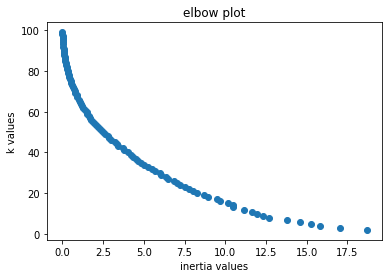

In [116]:
plt.scatter(x = inertia,y =K)
plt.xlabel('inertia values')
plt.ylabel('k values')
plt.title('elbow plot')

##### between 20 to 40 seems like the optimal k value

In [129]:
# set number of clusters
kclusters = 30 # using optimal k value later

toronto_grpd_clustering = toronto_grpd.drop('Postal Code', 1)

toronto_grpd_clustering.head()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grpd_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([14, 11,  1, 13,  2, 22, 13,  1,  1, 23, 29,  7, 22,  1,  8,  1, 28,
       22,  2,  1, 24, 22, 21,  1, 26, 13, 25,  1, 22, 13, 16,  3,  1,  1,
       22, 22, 22, 22, 22, 12, 22, 22,  6, 12,  0, 22, 20, 13, 12, 22, 22,
       22, 22, 22, 22, 22, 22, 10, 22, 22, 22,  9, 19, 22, 22, 22, 22, 22,
       22, 22, 22, 25,  5, 22, 22, 22, 22,  5, 13,  1, 22, 22, 22, 13, 22,
       22, 12, 22, 18, 27, 22, 18, 15, 22, 17,  0, 12,  1,  1, 22,  4, 12])

In [134]:
# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',axis = 1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = result

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

toronto_merged = toronto_merged.dropna() #removing missing values
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head()

,Postal Code,Borough,Neighborhood,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.808626,-79.189913,14,Trail,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785779,-79.157368,11,Construction & Landscaping,Bar,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Food Court
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765806,-79.185284,1,Pizza Place,Fast Food Restaurant,Coffee Shop,Filipino Restaurant,Thrift / Vintage Store,Restaurant,Supermarket,Bank,Fried Chicken Joint,Intersection
3,M1G,Scarborough,Woburn,43.771545,-79.218135,13,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Yoga Studio,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813,2,Construction & Landscaping,Trail,Fast Food Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Field,Eastern European Restaurant


In [136]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['lat'], toronto_merged['long'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters